In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from transformers import BertTokenizer, BertModel
import torch

# Load the CSV file into a pandas DataFrame
df = pd.read_csv("/content/cleaned_ghc_train.csv")


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

df['text'] = df['text'].fillna('')

In [3]:
y = df['label']
X=df['text']

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
top_words = 10000
max_review_length = 600
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, max_review_length)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **LSTM**

In [6]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
import numpy as np
from sklearn.metrics import classification_report, recall_score

# Define model
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

# Define checkpoint
filepath = "weights_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
callbacks_list = [checkpoint]

# Fit the model with class weights
model.fit(X_train, y_train, epochs=5, batch_size=256, verbose=1, callbacks=callbacks_list, class_weight=class_weight_dict)

# Load the best weights
model.load_weights("weights_best.hdf5")

# Evaluate the model
scores = model.evaluate(X_test, y_test, verbose=1, batch_size=256)
print("Accuracy: %.2f%%" % (scores[1]*100))

# Predict the probabilities
y_pred_probs = model.predict(X_test, batch_size=256, verbose=1)

# Find the best threshold for recall
thresholds = np.arange(0.1, 1, 0.01)
best_recall = 0
best_recall_threshold = 0.5

for threshold in thresholds:
    y_pred_classes = (y_pred_probs >= threshold).astype(int)
    recall = recall_score(y_test, y_pred_classes)

    if recall > best_recall:
        best_recall = recall
        best_recall_threshold = threshold

print(f"Best Recall Score: {best_recall:.4f} at threshold {best_recall_threshold:.2f}")

# Evaluate and print classification report for best recall score
y_pred_classes = (y_pred_probs >= best_recall_threshold).astype(int)
print("Classification Report for Best Recall Score:")
print(classification_report(y_test, y_pred_classes, target_names=['Class 0', 'Class 1']))


Epoch 1/5
69/69 [==============================] - ETA: 0s - loss: 0.6727 - accuracy: 0.6284
Epoch 1: accuracy improved from -inf to 0.62836, saving model to weights_best.hdf5
69/69 [==============================] - 158s 2s/step - loss: 0.6727 - accuracy: 0.6284
Epoch 2/5
69/69 [==============================] - ETA: 0s - loss: 0.5231 - accuracy: 0.7752
Epoch 2: accuracy improved from 0.62836 to 0.77520, saving model to weights_best.hdf5
69/69 [==============================] - 146s 2s/step - loss: 0.5231 - accuracy: 0.7752
Epoch 3/5
69/69 [==============================] - ETA: 0s - loss: 0.3696 - accuracy: 0.8520
Epoch 3: accuracy improved from 0.77520 to 0.85195, saving model to weights_best.hdf5
69/69 [==============================] - 148s 2s/step - loss: 0.3696 - accuracy: 0.8520
Epoch 4/5
69/69 [==============================] - ETA: 0s - loss: 0.2877 - accuracy: 0.8773
Epoch 4: accuracy improved from 0.85195 to 0.87727, saving model to weights_best.hdf5
69/69 [================

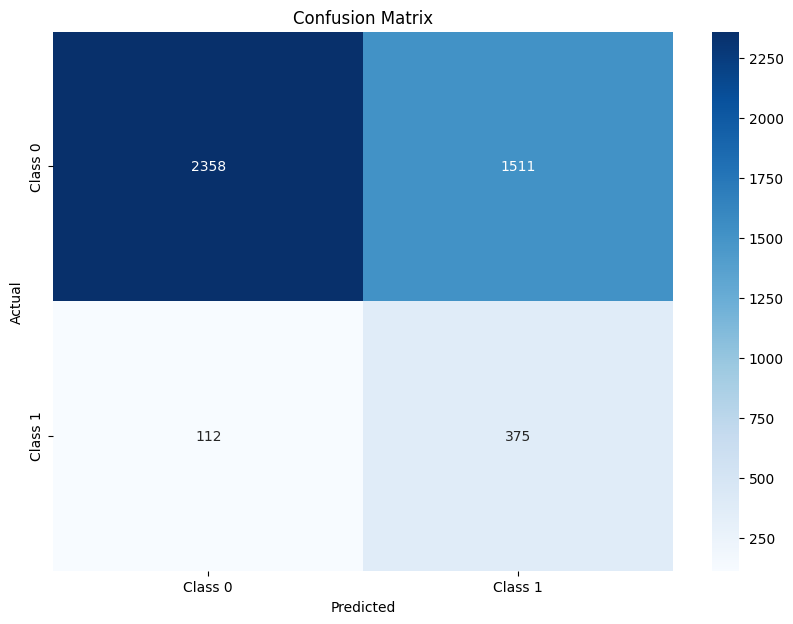

In [7]:
from sklearn.metrics import recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# **Biderctional LSTM**

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional
from keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
import numpy as np
from sklearn.metrics import classification_report, recall_score

# Define model
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

# Define checkpoint
filepath = "weights_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
callbacks_list = [checkpoint]

# Fit the model with class weights
model.fit(X_train, y_train, epochs=5, batch_size=256, verbose=1, callbacks=callbacks_list, class_weight=class_weight_dict)

# Load the best weights
model.load_weights("weights_best.hdf5")

# Evaluate the model
scores = model.evaluate(X_test, y_test, verbose=1, batch_size=256)
print("Accuracy: %.2f%%" % (scores[1]*100))

# Predict the probabilities
y_pred_probs = model.predict(X_test, batch_size=256, verbose=1)

# Find the best threshold for recall
thresholds = np.arange(0.1, 1, 0.01)
best_recall = 0
best_recall_threshold = 0.5

for threshold in thresholds:
    y_pred_classes = (y_pred_probs >= threshold).astype(int)
    recall = recall_score(y_test, y_pred_classes)

    if recall > best_recall:
        best_recall = recall
        best_recall_threshold = threshold

print(f"Best Recall Score: {best_recall:.4f} at threshold {best_recall_threshold:.2f}")

# Evaluate and print classification report for best recall score
y_pred_classes = (y_pred_probs >= best_recall_threshold).astype(int)
print("Classification Report for Best Recall Score:")
print(classification_report(y_test, y_pred_classes, target_names=['Class 0', 'Class 1']))


Epoch 1/5
69/69 [==============================] - ETA: 0s - loss: 0.6667 - accuracy: 0.5823
Epoch 1: accuracy improved from -inf to 0.58226, saving model to weights_best.hdf5
69/69 [==============================] - 294s 4s/step - loss: 0.6667 - accuracy: 0.5823
Epoch 2/5
69/69 [==============================] - ETA: 0s - loss: 0.5509 - accuracy: 0.7853
Epoch 2: accuracy improved from 0.58226 to 0.78530, saving model to weights_best.hdf5
69/69 [==============================] - 286s 4s/step - loss: 0.5509 - accuracy: 0.7853
Epoch 3/5
69/69 [==============================] - ETA: 0s - loss: 0.3949 - accuracy: 0.8521
Epoch 3: accuracy improved from 0.78530 to 0.85212, saving model to weights_best.hdf5
69/69 [==============================] - 288s 4s/step - loss: 0.3949 - accuracy: 0.8521
Epoch 4/5
69/69 [==============================] - ETA: 0s - loss: 0.3096 - accuracy: 0.8789
Epoch 4: accuracy improved from 0.85212 to 0.87887, saving model to weights_best.hdf5
69/69 [================

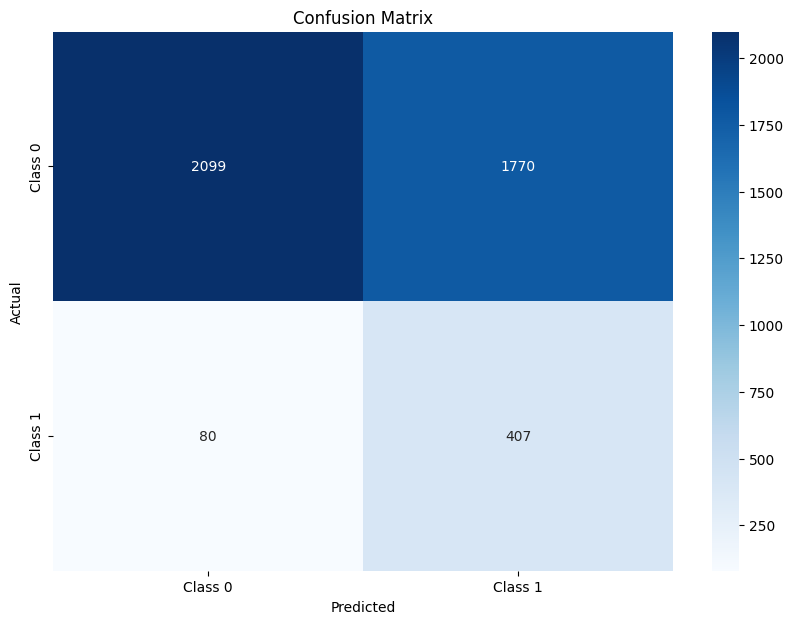

In [ ]:
from sklearn.metrics import recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Predict using the best recall threshold
y_pred_classes = (y_pred_probs >= best_recall_threshold).astype(int)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## **CNN**

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, recall_score
import numpy as np

# Define model
embedding_vector_length = 32
#top_words = 5000  # Adjust this based on your vocabulary size
#max_review_length = 500  # Adjust this based on your input sequence length

model = Sequential()
model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

# Define checkpoint
filepath = "weights_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
callbacks_list = [checkpoint]

# Fit the model with class weights
model.fit(X_train, y_train, epochs=5, batch_size=256, verbose=1, callbacks=callbacks_list, class_weight=class_weight_dict)

# Load the best weights
model.load_weights("weights_best.hdf5")

# Predict the probabilities
y_pred_probs = model.predict(X_test, batch_size=256, verbose=1)

# Find the best threshold for recall
thresholds = np.arange(0.1, 1, 0.01)
best_recall = 0
best_recall_threshold = 0.5

for threshold in thresholds:
    y_pred_classes = (y_pred_probs >= threshold).astype(int)
    recall = recall_score(y_test, y_pred_classes)

    if recall > best_recall:
        best_recall = recall
        best_recall_threshold = threshold

print(f"Best Recall Score: {best_recall:.4f} at threshold {best_recall_threshold:.2f}")

# Evaluate the model
scores = model.evaluate(X_test, y_test, verbose=1, batch_size=256)
print("Accuracy: %.2f%%" % (scores[1] * 100))

# Predict the labels using the best threshold
y_pred_classes = (y_pred_probs >= best_recall_threshold).astype(int)

# Print classification report
print(classification_report(y_test, y_pred_classes, target_names=['Class 0', 'Class 1']))


Epoch 1/5
69/69 [==============================] - ETA: 0s - loss: 0.6811 - accuracy: 0.4482
Epoch 1: accuracy improved from -inf to 0.44822, saving model to weights_best.hdf5
69/69 [==============================] - 11s 115ms/step - loss: 0.6811 - accuracy: 0.4482
Epoch 2/5
69/69 [==============================] - ETA: 0s - loss: 0.5271 - accuracy: 0.7677
Epoch 2: accuracy improved from 0.44822 to 0.76768, saving model to weights_best.hdf5
69/69 [==============================] - 7s 97ms/step - loss: 0.5271 - accuracy: 0.7677
Epoch 3/5
69/69 [==============================] - ETA: 0s - loss: 0.3583 - accuracy: 0.8701
Epoch 3: accuracy improved from 0.76768 to 0.87015, saving model to weights_best.hdf5
69/69 [==============================] - 4s 60ms/step - loss: 0.3583 - accuracy: 0.8701
Epoch 4/5
69/69 [==============================] - ETA: 0s - loss: 0.2317 - accuracy: 0.9181
Epoch 4: accuracy improved from 0.87015 to 0.91814, saving model to weights_best.hdf5
69/69 [==============

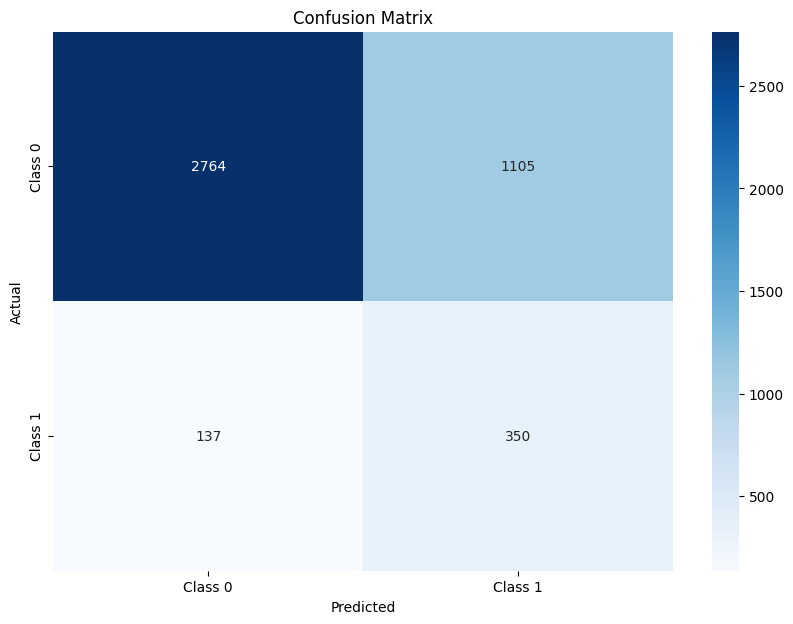

In [ ]:
y_pred_classes = (y_pred_probs >= best_recall_threshold).astype(int)

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# **LSTM WITH CNN**

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Conv1D, MaxPooling1D, Dropout
from keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
import numpy as np
from sklearn.metrics import classification_report, recall_score

# Define parameters
embedding_vector_length = 32
 # Adjust this based on your vocabulary size
  # Adjust this based on your input sequence length

# Define model
model = Sequential()
model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

# Define checkpoint for best accuracy
checkpoint = ModelCheckpoint("weights_best.hdf5", monitor='accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
callbacks_list = [checkpoint]

# Fit the model with class weights
# Fit the model with class weights
model.fit(X_train, y_train, epochs=5, batch_size=256, verbose=1, callbacks=callbacks_list, class_weight=class_weight_dict)

# Load the best weights for evaluation
model.load_weights("weights_best.hdf5")

# Evaluate the model
scores = model.evaluate(X_test, y_test, verbose=1, batch_size=256)
print("Accuracy: %.2f%%" % (scores[1] * 100))

# Predict the probabilities
y_pred_probs = model.predict(X_test, batch_size=256, verbose=1)

# Find the best threshold for recall
thresholds = np.arange(0.1, 1, 0.01)
best_recall = 0
best_recall_threshold = 0.5

for threshold in thresholds:
    y_pred_classes = (y_pred_probs >= threshold).astype(int)
    recall = recall_score(y_test, y_pred_classes)

    if recall > best_recall:
        best_recall = recall
        best_recall_threshold = threshold

print(f"Best Recall Score: {best_recall:.4f} at threshold {best_recall_threshold:.2f}")

# Evaluate and print classification report for best recall score
y_pred_classes = (y_pred_probs >= best_recall_threshold).astype(int)
print("Classification Report for Best Recall Score:")
print(classification_report(y_test, y_pred_classes, target_names=['Class 0', 'Class 1']))


Epoch 1/5
69/69 [==============================] - ETA: 0s - loss: 0.6717 - accuracy: 0.5987
Epoch 1: accuracy improved from -inf to 0.59868, saving model to weights_best.hdf5
69/69 [==============================] - 330s 5s/step - loss: 0.6717 - accuracy: 0.5987
Epoch 2/5
69/69 [==============================] - ETA: 0s - loss: 0.4872 - accuracy: 0.8163
Epoch 2: accuracy improved from 0.59868 to 0.81630, saving model to weights_best.hdf5
69/69 [==============================] - 318s 5s/step - loss: 0.4872 - accuracy: 0.8163
Epoch 3/5
69/69 [==============================] - ETA: 0s - loss: 0.3300 - accuracy: 0.8801
Epoch 3: accuracy improved from 0.81630 to 0.88014, saving model to weights_best.hdf5
69/69 [==============================] - 321s 5s/step - loss: 0.3300 - accuracy: 0.8801
Epoch 4/5
69/69 [==============================] - ETA: 0s - loss: 0.2444 - accuracy: 0.9053
Epoch 4: accuracy improved from 0.88014 to 0.90534, saving model to weights_best.hdf5
69/69 [================

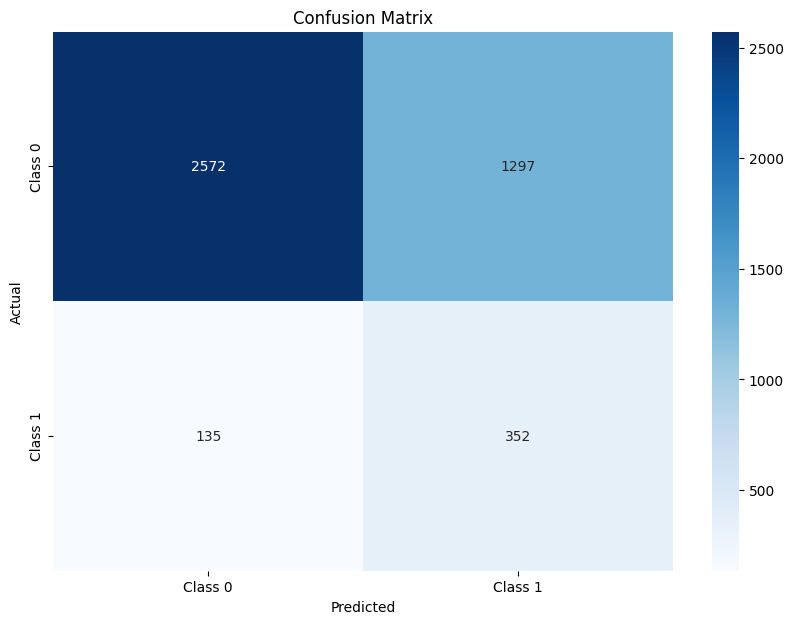

In [ ]:
from sklearn.metrics import recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Evaluate for best recall threshold
y_pred_classes = (y_pred_probs >= best_recall_threshold).astype(int)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# CONCLUSION

CNN model is the best choice due to its high accuracy with 85% and balanced performance across metrics